In [1]:
import pandas as pd
import random
from collections import Counter

df = pd.read_csv("../data/final/final_dataset.csv")

total = len(df)
valid_spans = ((df.secret_span_start >= 0) & (df.secret_span_end > df.secret_span_start)).sum()
invalid_spans = total - valid_spans

print(f"Total samples: {total}")
print(f"Valid spans: {valid_spans} ({valid_spans/total:.2%})")
print(f"No span / invalid: {invalid_spans} ({invalid_spans/total:.2%})")

print("\nBreakdown by source:")
print(df.groupby("source")["secret_span_start"]
      .apply(lambda s: ((s == 0).sum(), len(s))))

Total samples: 8496
Valid spans: 2953 (34.76%)
No span / invalid: 5543 (65.24%)

Breakdown by source:
source
contextual_negative       (0, 1567)
gitleaks                 (508, 759)
hard_negative             (0, 1500)
random_negative            (0, 706)
synthetic                 (0, 2360)
trufflehog             (1604, 1604)
Name: secret_span_start, dtype: object


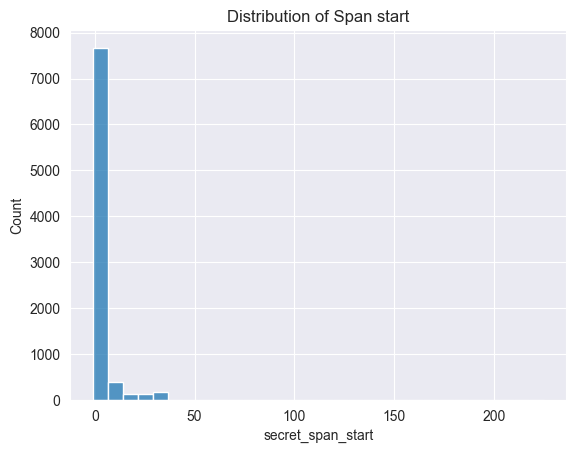

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['secret_span_start'], bins=30)
plt.title('Distribution of Span start')
plt.savefig('histogram_plot.png')

In [3]:
import pandas as pd

# CONFIG
# Probability to augment samples with span_start == 0
AUGMENT_ZERO_SPAN_PROB = 0.85

INPUT_CSV = "../data/final/final_dataset.csv"
OUTPUT_CSV = "../data/final/final_dataset_span_fixed.csv"

# Apply augmentation only to these sources
ALLOWED_SOURCES = {"gitleaks", "trufflehog"}

# Probability of structural wrapper
STRUCTURAL_PROB = 0.35


# PREFIX / STRUCTURAL CONTEXT
PREFIX_LINES = [
    "import os\n",
    "import sys\n",
    "import json\n",
    "import logging\n",
    "from typing import Optional\n",
    "from pathlib import Path\n",

    "# configuration\n",
    "# initialization\n",
    "# setup environment\n",
    "# load settings\n",
    "# TODO: cleanup\n",

    "logging.basicConfig(level=logging.INFO)\n",
    "logger = logging.getLogger(__name__)\n",

    "ENV = os.getenv('ENV', 'dev')\n",
    "DEBUG = ENV != 'prod'\n",

    "def setup():\n    pass\n",
    "def init():\n    return None\n",

    "class Config:\n    pass\n",

    "if __name__ == '__main__':\n    pass\n",

    "/* setup */\n",
    "// initialization\n",
    "\n",
]

STRUCTURAL_TEMPLATES = [

    # Functions
    "def load_config():\n    {line}\n    return True\n",

    "def get_settings():\n    {line}\n    return {{}}\n",

    "def initialize():\n    {line}\n",

    "def connect():\n    {line}\n    return None\n",

    "def bootstrap():\n    {line}\n",

    # Classes
    "class Client:\n    def __init__(self):\n        {line}\n",

    "class Service:\n    def setup(self):\n        {line}\n",

    "class Config:\n    def load(self):\n        {line}\n",

    "class App:\n    def __init__(self):\n        {line}\n",

    # Conditionals
    "if DEBUG:\n    {line}\n",

    "if os.getenv('ENV') == 'dev':\n    {line}\n",

    "if True:\n    {line}\n",

    # Try / Except
    "try:\n    {line}\nexcept Exception:\n    pass\n",

    "try:\n    {line}\nfinally:\n    pass\n",

    # Context Managers
    "with open('config.txt') as f:\n    {line}\n",

    "with suppress(Exception):\n    {line}\n",

    # JS-style
    "function init() {{\n    {line}\n}}\n",

    "const setup = () => {{\n    {line}\n}};\n",

    "export function load() {{\n    {line}\n}}\n",

    # JSON / YAML
    "{{\n  \"config\": {{\n    {line}\n  }}\n}}\n",

    "settings:\n  app:\n    {line}\n",

    # Shell / Docker
    "RUN echo \"starting\" && \\\n    {line}\n",

    "CMD [\"sh\", \"-c\", \"{line}\"]\n",

    # Misc
    "/* auto-generated */\n{line}\n",

    "// bootstrap\n{line}\n",

    "### CONFIGURATION ###\n{line}\n",
]


# UTILITIES
def span_bucket(start: int) -> str:
    if start == 0:
        return "0"
    if start <= 50:
        return "1–50"
    if start <= 200:
        return "51–200"
    return "200+"

def report_distribution(df, title):
    buckets = Counter(span_bucket(s) for s in df["secret_span_start"])
    total = len(df)

    print(f"\n{title}")
    print("-" * 60)
    for k in ["0", "1–50", "51–200", "200+"]:
        count = buckets.get(k, 0)
        pct = 100 * count / total
        print(f"{k:>6}: {count:5d}  ({pct:5.1f}%)")
    print("-" * 60)



# LOAD
df = pd.read_csv(INPUT_CSV)

print(f"Loaded dataset: {len(df)} samples")


# BEFORE DISTRIBUTION
report_distribution(df, "BEFORE span-start distribution")


# AUGMENTATION
def apply_prefix_padding(row):
    snippet = row["code_snippet"]
    start = row["secret_span_start"]
    end = row["secret_span_end"]

    # Sanity check
    if start != 0 or row["source"] not in ALLOWED_SOURCES:
        return row

    # Probabilistic skip to preserve some start=0 samples
    if random.random() > AUGMENT_ZERO_SPAN_PROB:
        return row

    # Decide augmentation type
    use_structural = random.random() < STRUCTURAL_PROB

    if use_structural:
        template = random.choice(STRUCTURAL_TEMPLATES)
        wrapped = template.format(line=snippet)
        offset = wrapped.index(snippet)
        row["code_snippet"] = wrapped
        row["secret_span_start"] = start + offset
        row["secret_span_end"] = end + offset
    else:
        k = random.randint(1, 5)
        prefix = "".join(random.choices(PREFIX_LINES, k=k))
        row["code_snippet"] = prefix + snippet
        row["secret_span_start"] = start + len(prefix)
        row["secret_span_end"] = end + len(prefix)

    return row

# Apply only to rows with span_start == 0
mask = (
    (df["secret_span_start"] == 0) &
    (df["has_secret"] == 1) &
    (df["source"].isin(ALLOWED_SOURCES))
)

affected = mask.sum()
print(f"\nApplying prefix-padding to {affected} samples")

df.loc[mask] = df.loc[mask].apply(apply_prefix_padding, axis=1)

# AFTER DISTRIBUTION
report_distribution(df, "AFTER span-start distribution")


# SAVE
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nSaved span-fixed dataset → {OUTPUT_CSV}")

Loaded dataset: 8496 samples

BEFORE span-start distribution
------------------------------------------------------------
     0:  2112  ( 24.9%)
  1–50:  6367  ( 74.9%)
51–200:    16  (  0.2%)
  200+:     1  (  0.0%)
------------------------------------------------------------

Applying prefix-padding to 2112 samples

AFTER span-start distribution
------------------------------------------------------------
     0:   337  (  4.0%)
  1–50:  7452  ( 87.7%)
51–200:   706  (  8.3%)
  200+:     1  (  0.0%)
------------------------------------------------------------

Saved span-fixed dataset → ../data/final/final_dataset_span_fixed.csv


In [4]:
df

,source,code_snippet,secret,secret_span_start,secret_span_end,file_path,line_number,length,entropy,rule,rule_group,has_secret,obfuscation_type,hard_negative
0,contextual_negative,# generated via a Jupyter notebook(/lear/tests...,NaN,-1,-1,legal-api/migrations/versions/40015e4aa4f5_add...,83,0,0.000000,none,none,0,none,0
1,gitleaks,const setup = () => {\n 089a5797be612b18a82...,089a5797be612b18a820f9f1e6593ad9a91b1dba,26,66,data/all.json,51984,40,3.634830,sourcegraph-access-token,vendor_api,1,none,0
2,trufflehog,tdOqFqJLOUarP6ZzO6V9HOgPHczqnc,tdOqFqJLOUarP6ZzO6V9HOgPHczqnc,0,30,/var/folders/mj/znx7lb6x1032hhf0_dlvvp3r0000gn...,1,30,4.148394,Nimble,vendor_api,1,none,0
3,contextual_negative,"""MIGHAgEAMBMGByqGSM49AgEGCCqGSM49AwEHBG0wawIBA...",NaN,-1,-1,test/jdk/javax/net/ssl/interop/ClientHelloInte...,146,0,0.000000,none,none,0,none,0
4,synthetic,"API_KEY = ""5dxZcj5Zim1PB4wC3tDYrChD5iclHVRtJYB...",5dxZcj5Zim1PB4wC3tDYrChD5iclHVRtJYBUbvT,11,50,-1,-1,39,4.753200,linkedin-client-secret,auth_token,1,clean,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8491,contextual_negative,# main_app.py\nfrom syqlorix import Syqlorix,NaN,-1,-1,README.md,172,0,0.000000,none,none,0,none,0
8492,contextual_negative,""""""", KeyPair.class, ""SunEC"");\n\n public st...",NaN,-1,-1,test/jdk/java/security/PEM/PEMData.java,60,0,0.000000,none,none,0,none,0
8493,contextual_negative,```python\nclass LoginModel(BaseModel):,NaN,-1,-1,README.md,156,0,0.000000,none,none,0,none,0
8494,trufflehog,"ENV = os.getenv('ENV', 'dev')\nclass Config:\n...",-boston-celtics-jersey-psa-dna-coa-2,100,136,/var/folders/mj/znx7lb6x1032hhf0_dlvvp3r0000gn...,97,36,3.762396,TatumIO,vendor_api,1,none,0
